In [ ]:
import torch
import espaloma as esp

In [4]:
%%capture
! wget http://data.wangyq.net/espaloma_model.pt

In [2]:
model = torch.load("espaloma-0.2.2.pt")

Using backend: pytorch


In [3]:
import qcportal as ptl
client = ptl.FractalClient()
collection = client.get_collection("TorsionDriveDataset", "OpenFF Fragmenter Phenyl Benchmark")
record_names = list(collection.data.records)

In [13]:
def get_graph(collection, record_name):
    record = collection.get_record(record_name, specification="B3LYP-D3")
    entry = collection.get_entry(record_name)
    from openff.toolkit.topology import Molecule
    from simtk import unit
    from simtk.unit import Quantity
    
    mols = record.get_final_molecules()
    energies = record.get_final_energies()
    
    mol_and_energy = [
        (mols[key], energies[key], key) for key in mols.keys()
    ]
    
    mol = Molecule.from_qcschema(entry)
    g = esp.Graph(mol)
    from espaloma.graphs.utils.regenerate_impropers import regenerate_impropers
    g = regenerate_impropers(g)
    g.nodes['g'].data['u_ref'] = torch.tensor(
        [
            Quantity(
                energy,
                esp.units.HARTREE_PER_PARTICLE,
            ).value_in_unit(esp.units.ENERGY_UNIT)
            for mol, energy, key in mol_and_energy
        ],
        dtype=torch.get_default_dtype(),
    )[None, :]
    
    g.nodes['g'].data['key'] = torch.tensor(
        [
            key for mol, energy, key in mol_and_energy
        ],
        dtype=torch.get_default_dtype(),
    )[None, :]


    import numpy as np
    
    x = torch.tensor(
        np.stack(
            [
                Quantity(
                    mol['geometry'],
                    unit.bohr,
                ).value_in_unit(esp.units.DISTANCE_UNIT)
                for mol, energy, key in mol_and_energy
            ],
            axis=1,
        ),
        requires_grad=True,
        dtype=torch.get_default_dtype(),
    )
    
    
    g.nodes["n1"].data["xyz"] = torch.tensor(
        np.stack(
            [
                Quantity(
                    mol['geometry'],
                    unit.bohr,
                ).value_in_unit(esp.units.DISTANCE_UNIT)
                for mol, energy, key in mol_and_energy
            ],
            axis=1,
        ),
        requires_grad=True,
        dtype=torch.get_default_dtype(),
    )
    

    return g

In [7]:
def plot(idx):
    g = get_graph(collection, record_names[idx])
    model(g.heterograph)
    esp.mm.geometry.geometry_in_graph(g.heterograph)
    esp.mm.energy.energy_in_graph(g.heterograph, terms=["n2", "n3", "n4", "n4_improper"])
    esp.data.md.add_nonbonded_force(g, forcefield="openff-1.2.0")
    
    from matplotlib import rcParams
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Helvetica']
    from matplotlib import pyplot as plt
    from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
    import matplotlib.image as mpimg


    fig, ax = plt.subplots(figsize=(8, 4))
    idxs = g.nodes['g'].data['key'].flatten().argsort()

    mol_img = mpimg.imread("http://hulab.rxnfinder.org/smi2img/%s/?width=100&height=100" % g.mol.to_smiles(explicit_hydrogens=False))
    img_box = OffsetImage(mol_img)
    annotation = AnnotationBbox(img_box, (90, -2), frameon=False, zorder=0)
    ax.add_artist(annotation)

    rmse = 627.5 * esp.metrics.center(esp.metrics.rmse)(
        g.nodes['g'].data['u'],
        g.nodes['g'].data['u_ref']
    )

    ax.plot(
        g.nodes['g'].data['key'].detach().flatten()[idxs],
        627.5 * (g.nodes['g'].data['u'].detach().flatten()[idxs] - g.nodes['g'].data['u'].detach().flatten().mean()),
        "-o",
        label="espaloma"
    )

    ax.plot(
        g.nodes['g'].data['key'].detach().flatten()[idxs],
        627.5 * (g.nodes['g'].data['u_ref'].detach().flatten()[idxs] - g.nodes['g'].data['u_ref'].detach().flatten().mean()),
        "-o",
        label="qm",
    )

    ax.legend()
    ax.set_xlabel("dihedral angle (degrees)")
    ax.set_ylabel("centered energy (kcal/mol)")
    ax.set_title("RMSE: %.4f kcal/mol" % rmse)
    
    plt.savefig("%s.png" % idx, dpi=300)
    return None


/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: dgl.to_homo is deprecated. Please use dgl.to_homogeneous
  return warnings.warn(message, category=category, stacklevel=1)
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no lon

/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: dgl.to_homo is deprecated. Please use dgl.to_homogeneous
  return warnings.warn(message, category=category, stacklevel=1)
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.war

/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: dgl.to_homo is deprecated. Please use dgl.to_homogeneous
  return warnings.warn(message, category=category, stacklevel=1)
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.war

/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: dgl.to_homo is deprecated. Please use dgl.to_homogeneous
  return warnings.warn(message, category=category, stacklevel=1)
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no lon

/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: dgl.to_homo is deprecated. Please use dgl.to_homogeneous
  return warnings.warn(message, category=category, stacklevel=1)
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.war

HTTPError: HTTP Error 500: INTERNAL SERVER ERROR

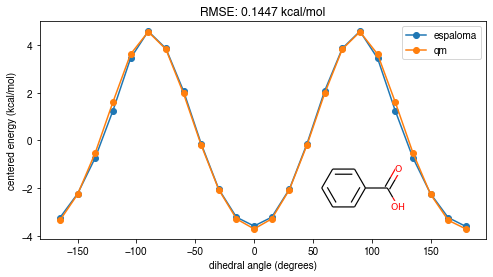

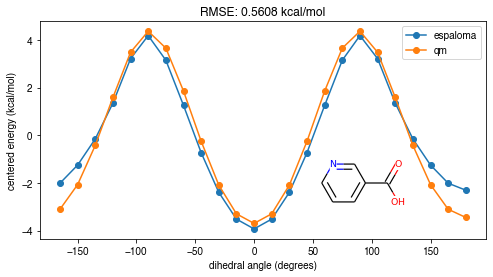

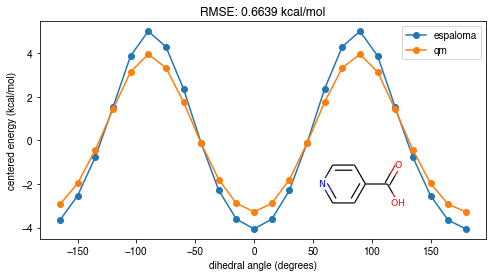

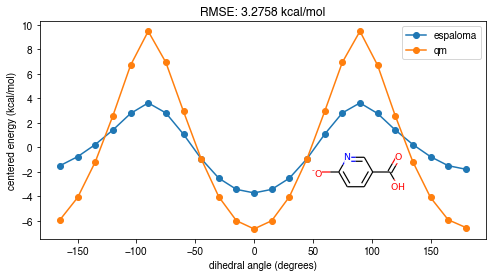

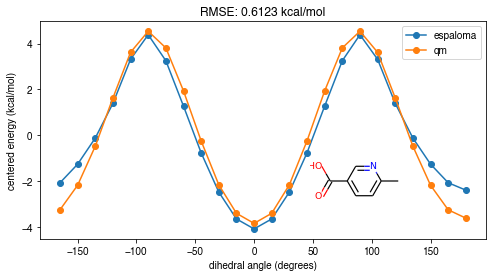

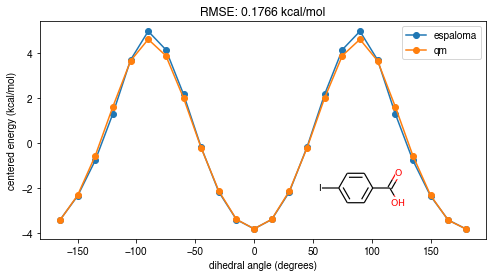

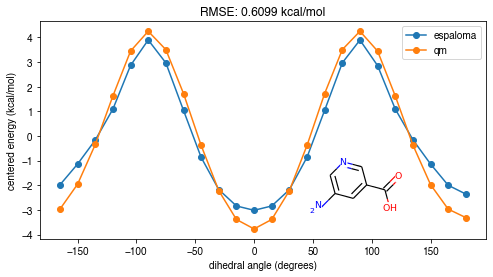

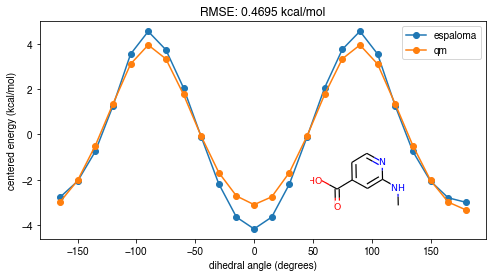

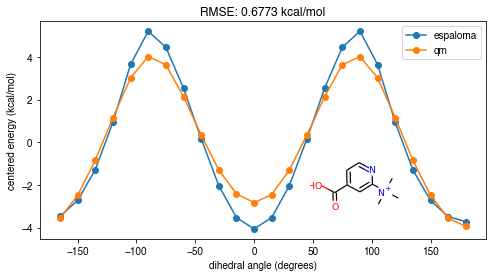

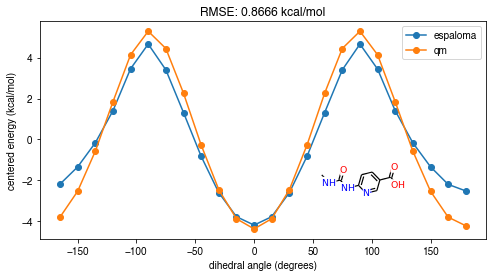

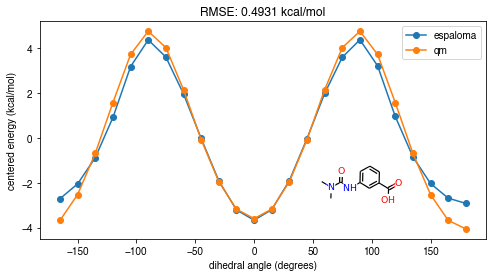

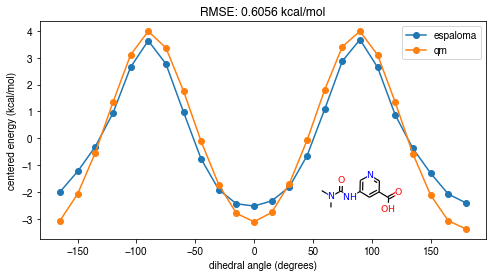

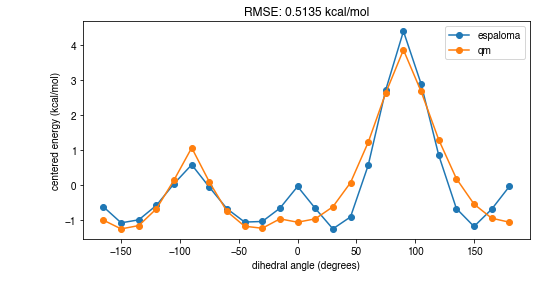

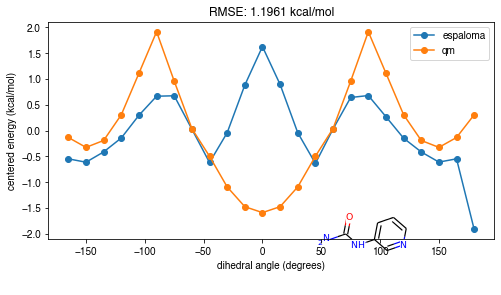

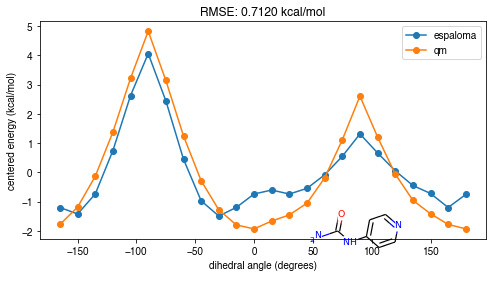

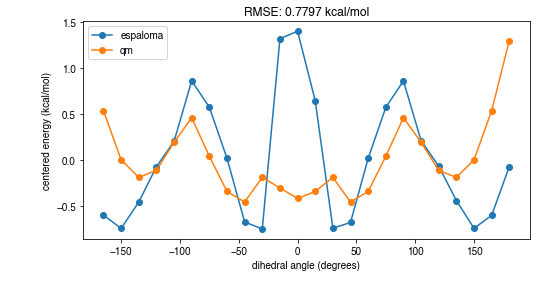

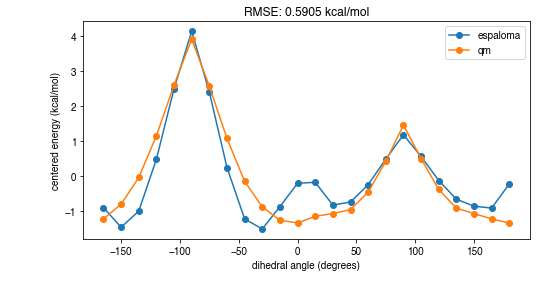

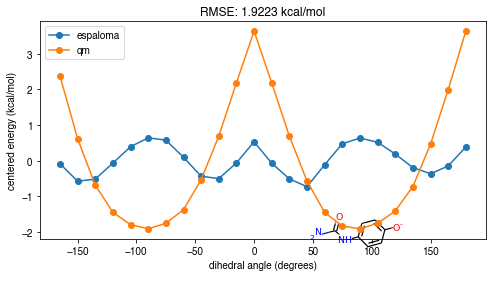

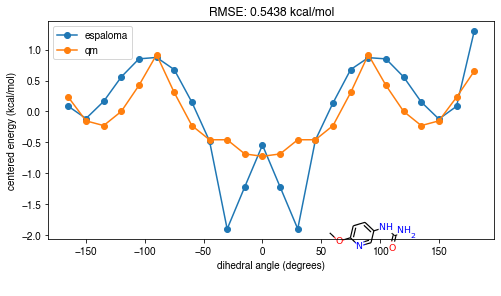

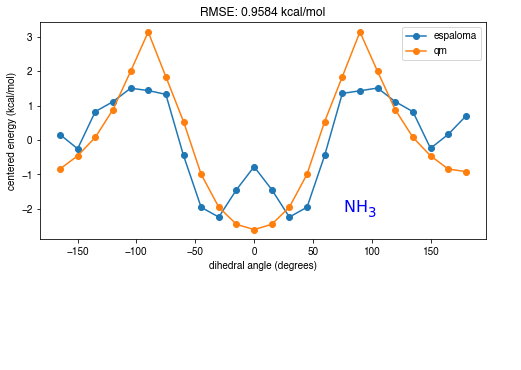

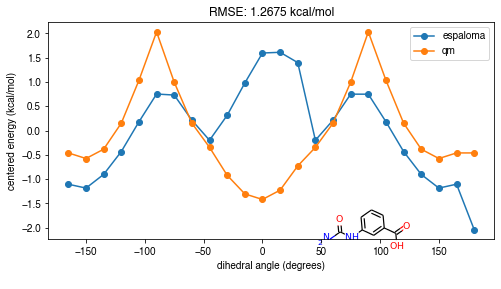

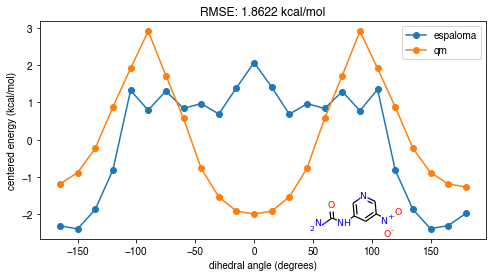

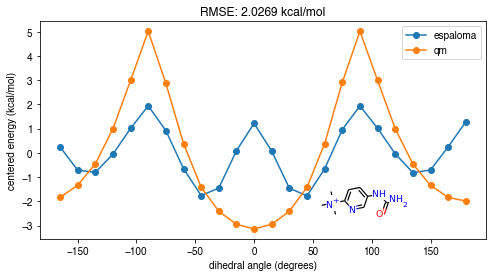

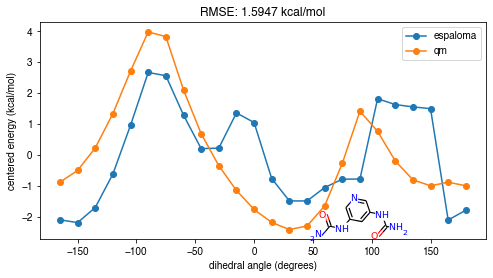

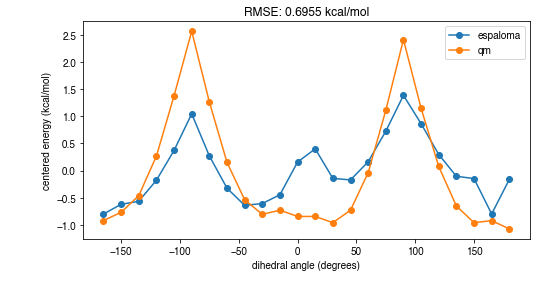

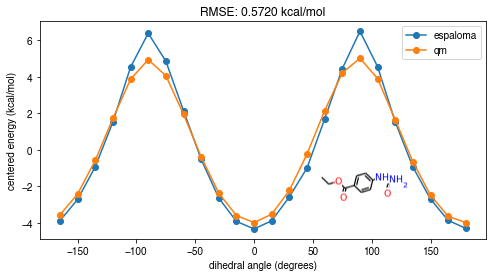

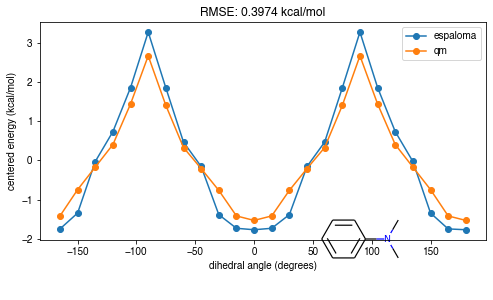

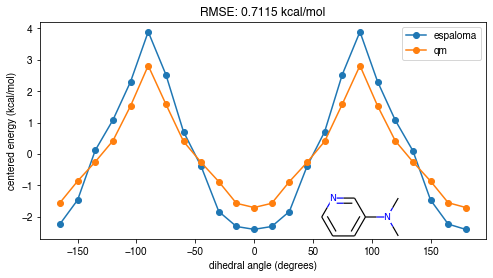

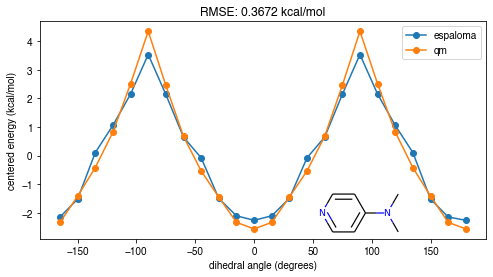

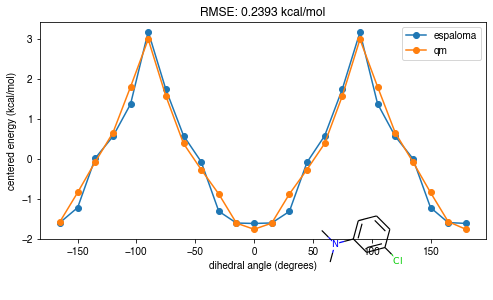

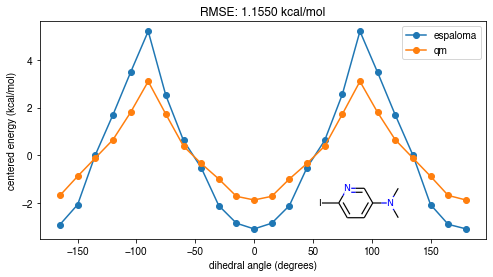

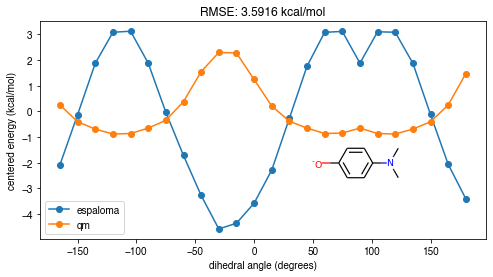

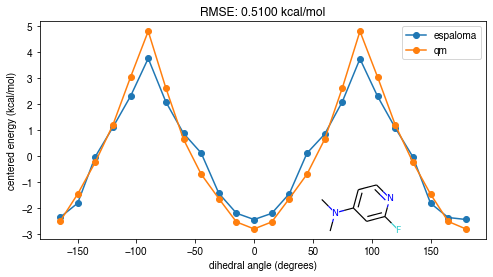

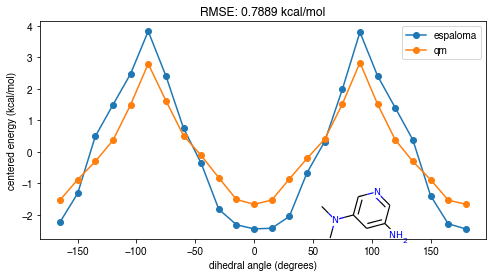

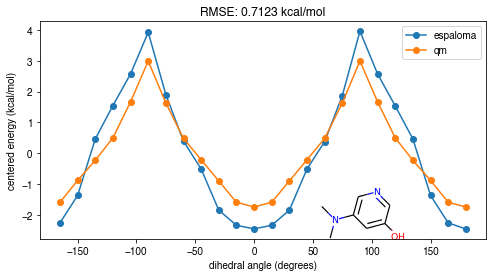

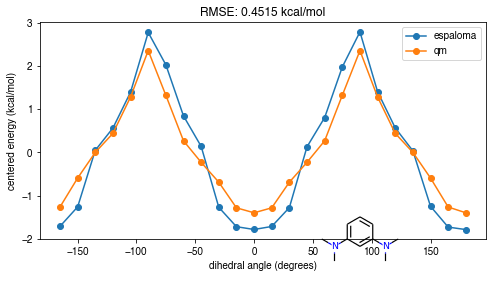

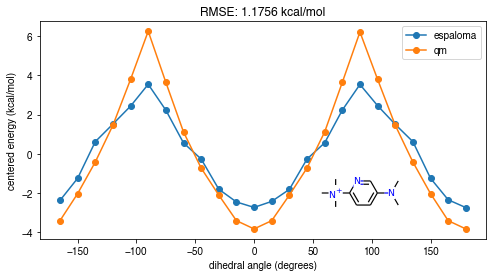

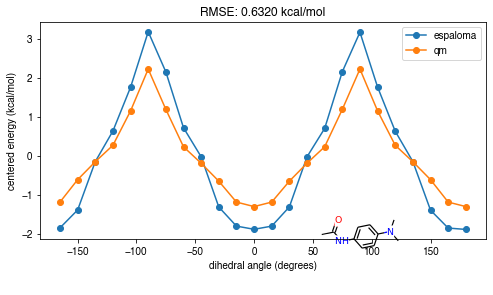

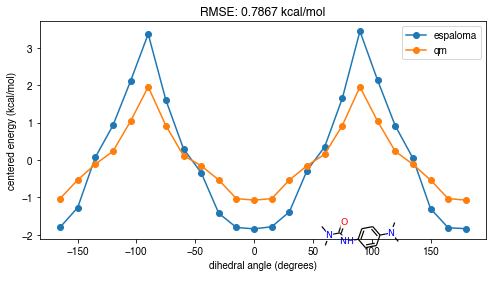

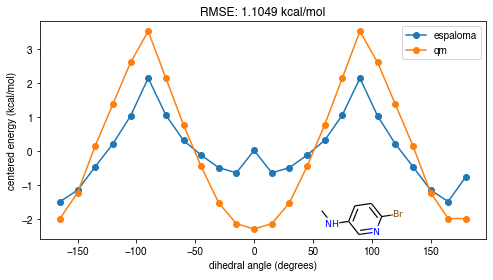

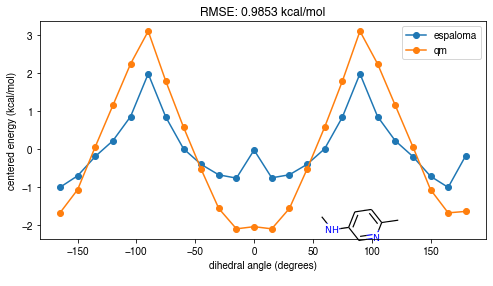

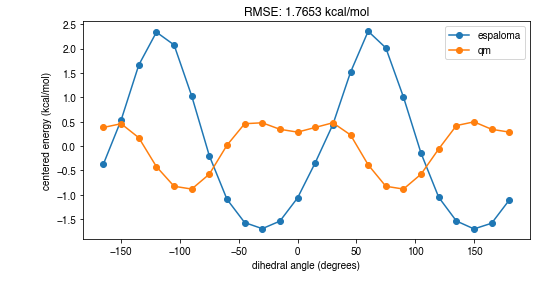

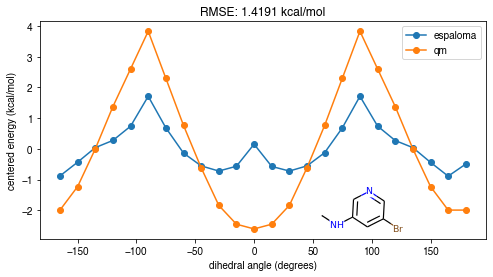

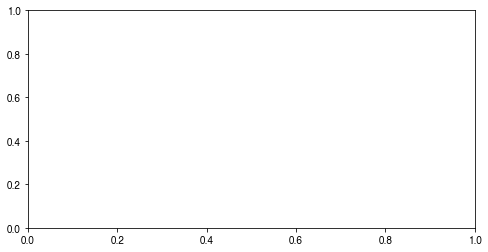

In [8]:
for idx in range(len(record_names)):
    plot(idx)

In [80]:
len(record_names)

227